In [1]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class NpzRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        # y shape이 (N,)이면 (N,1)로 바꿔주는 게 편할 때가 많음
        if self.y.ndim == 1:
            self.y = self.y.unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [3]:
import numpy as np
import torch

# record_index
# vector_index
# diff_indices
# diff_values
# cost

json_diffs = np.load("i_vectors_diffs.npz")

input_data = np.log(json_diffs["diff_values"]+1e-8)
# input_data = json_diffs["diff_values"]
cost = -np.log(json_diffs["cost"])

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(
    input_data, cost, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

train_dataset = NpzRegressionDataset(X_train_scaled, y_train)
val_dataset   = NpzRegressionDataset(X_val_scaled,   y_val)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False)

In [10]:
y_train

array([6.02046503, 7.04948476, 5.87399978, ..., 4.52013994, 4.22993751,
       2.47960274])

## Step 2: 개선된 모델 구조 및 하이퍼파라미터

**개선 전략:**
1. **모델 구조**: 더 깊고 넓은 네트워크 + Batch Normalization + Dropout
2. **Loss 함수**: 평활화된 L1 손실(Huber Loss) + 가중치 조정
3. **하이퍼파라미터**: 
   - 더 큰 hidden/latent 차원
   - 학습률 스케줄링 (Cosine Annealing)
   - Gradient Clipping
   - Early Stopping
4. **정규화**: Label Smoothing, Mixup 데이터 증강 고려

In [6]:
import torch.nn as nn

# 개선된 VAE 모델
class ImprovedVAE_regression(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, activation="relu", 
                 dropout=0.1, use_bn=True, regression=True):
        super(ImprovedVAE_regression, self).__init__()

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(0.2)
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

        self.use_bn = use_bn
        
        # Encoder (더 깊게)
        self.fc_e1 = nn.Linear(input_dim, hidden_dim)
        self.bn_e1 = nn.BatchNorm1d(hidden_dim) if use_bn else nn.Identity()
        self.dropout_e1 = nn.Dropout(dropout)
        
        self.fc_e2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn_e2 = nn.BatchNorm1d(hidden_dim) if use_bn else nn.Identity()
        self.dropout_e2 = nn.Dropout(dropout)
        
        self.fc_e3 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn_e3 = nn.BatchNorm1d(hidden_dim // 2) if use_bn else nn.Identity()
        
        self.fc_mean = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.fc_d1 = nn.Linear(latent_dim, hidden_dim // 2)
        self.bn_d1 = nn.BatchNorm1d(hidden_dim // 2) if use_bn else nn.Identity()
        self.dropout_d1 = nn.Dropout(dropout)
        
        self.fc_d2 = nn.Linear(hidden_dim // 2, hidden_dim)
        self.bn_d2 = nn.BatchNorm1d(hidden_dim) if use_bn else nn.Identity()
        self.dropout_d2 = nn.Dropout(dropout)
        
        self.fc_d3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn_d3 = nn.BatchNorm1d(hidden_dim) if use_bn else nn.Identity()
        
        self.fc_d4 = nn.Linear(hidden_dim, input_dim)

        self.regression = regression
        if regression:
            # 더 깊은 regression head
            self.regression_head = nn.Sequential(
                nn.Linear(latent_dim, 512),
                nn.BatchNorm1d(512) if use_bn else nn.Identity(),
                self.activation,
                nn.Dropout(dropout),
                
                nn.Linear(512, 512),
                nn.BatchNorm1d(512) if use_bn else nn.Identity(),
                self.activation,
                nn.Dropout(dropout),
                
                nn.Linear(512, 256),
                nn.BatchNorm1d(256) if use_bn else nn.Identity(),
                self.activation,
                nn.Dropout(dropout),
                
                nn.Linear(256, 128),
                nn.BatchNorm1d(128) if use_bn else nn.Identity(),
                self.activation,
                
                nn.Linear(128, 1),
            )

    def encode(self, x):
        h = self.activation(self.bn_e1(self.fc_e1(x)))
        h = self.dropout_e1(h)
        h = self.activation(self.bn_e2(self.fc_e2(h)))
        h = self.dropout_e2(h)
        h = self.activation(self.bn_e3(self.fc_e3(h)))
        return self.fc_mean(h), self.fc_logvar(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        h = self.activation(self.bn_d1(self.fc_d1(z)))
        h = self.dropout_d1(h)
        h = self.activation(self.bn_d2(self.fc_d2(h)))
        h = self.dropout_d2(h)
        h = self.activation(self.bn_d3(self.fc_d3(h)))
        return self.fc_d4(h)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        if self.regression:
            cost = self.regression_head(z)
        else:
            cost = None
        recon_x = self.decode(z)
        return recon_x, mean, logvar, cost

In [7]:
# 개선된 Loss 함수 (Huber Loss + 동적 가중치)
def improved_vae_loss(beta, recon_x, mean, logvar, x, cost_pred=None, y=None, 
                      huber_delta=1.0):
    
    b_recon, b_kl, b_reg = beta

    # Reconstruction loss - Huber Loss (이상치에 강함)
    recon_loss = F.smooth_l1_loss(recon_x, x, reduction='sum', beta=huber_delta)
    recon_loss = b_recon * recon_loss
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    KLD = b_kl * KLD

    if cost_pred is not None:
        # Regression loss - Huber Loss
        reg_loss = F.smooth_l1_loss(cost_pred, y, reduction='sum', beta=huber_delta)
        reg_loss = b_reg * reg_loss
        return recon_loss, KLD, reg_loss

    return recon_loss, KLD, 0.0

# Cosine Annealing with Warm Restarts
def cosine_annealing_with_warmup(epoch, num_epochs, beta_range, warmup_epochs=10):
    beta_start, beta_end = beta_range
    if epoch < warmup_epochs:
        # Warmup period
        beta = beta_start + (beta_end - beta_start) * (epoch / warmup_epochs)
    else:
        # Cosine annealing
        progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        beta = beta_end * 0.5 * (1 + np.cos(np.pi * progress))
        beta = max(beta, beta_start)
    return beta

In [ ]:
# 개선된 모델 학습 (버전 1)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("=== 개선된 모델 학습 시작 (v1) ===\n")

num_epochs = 300
input_dim = X_train.shape[1]

# 모델 초기화 (더 큰 용량)
model_v1 = ImprovedVAE_regression(
    input_dim=input_dim, 
    hidden_dim=1536,  # 1024 -> 1536
    latent_dim=64,    # 32 -> 64
    activation='elu',  # ELU는 음수 값에도 부드러운 기울기
    dropout=0.15,
    use_bn=True,
    regression=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v1.to(device)

# Optimizer with weight decay
optimizer_v1 = torch.optim.AdamW(model_v1.parameters(), lr=5e-4, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_v1, T_0=50, T_mult=2, eta_min=1e-6
)

# 하이퍼파라미터
b_recon = 1.0
b_kld_range = (0.0, 0.05)  # 0.03 -> 0.05
b_reg = 2.0  # 0.5 -> 1.0
huber_delta = 1.0

# Early stopping
best_val_loss = float('inf')
patience = 50
patience_counter = 0

# 학습 이력
history_v1 = {
    'train_loss': [], 'val_loss': [],
    'train_recon': [], 'train_kl': [], 'train_reg': [],
    'val_r2': [], 'lr': []
}

for epoch in range(num_epochs):
    # KL annealing with warmup
    b_kl = cosine_annealing_with_warmup(epoch, num_epochs, b_kld_range, warmup_epochs=20)
    # b_kl = 0.05
    beta = (b_recon, b_kl, b_reg)
    
    # --- Train ---
    model_v1.train()
    train_loss = 0.0
    train_recon_loss = 0.0
    train_kl_loss = 0.0
    train_reg_loss = 0.0
    
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        recon_x, mean, logvar, cost_pred = model_v1(xb)
        recon_loss, kl_loss, reg_loss = improved_vae_loss(
            beta, recon_x, mean, logvar, xb, cost_pred, yb, huber_delta
        )

        loss = recon_loss + kl_loss + reg_loss

        optimizer_v1.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_v1.parameters(), max_norm=1.0)
        
        optimizer_v1.step()

        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        train_reg_loss += reg_loss.item()
        train_loss += loss.item()
    
    train_loss /= len(train_dataset)
    train_recon_loss /= len(train_dataset)
    train_kl_loss /= len(train_dataset)
    train_reg_loss /= len(train_dataset)
    
    scheduler.step()

    # --- Validation ---
    model_v1.eval()
    val_loss = 0.0
    val_preds_list = []
    val_targets_list = []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            recon_x, mean, logvar, cost_pred = model_v1(xb)
            recon_loss, kl_loss, reg_loss = improved_vae_loss(
                beta, recon_x, mean, logvar, xb, cost_pred, yb, huber_delta
            )
            loss = recon_loss + kl_loss + reg_loss
            val_loss += loss.item()
            
            val_preds_list.append(cost_pred.cpu().numpy())
            val_targets_list.append(yb.cpu().numpy())

    val_loss /= len(val_dataset)
    
    # R² 계산
    val_preds_epoch = np.concatenate(val_preds_list)
    val_targets_epoch = np.concatenate(val_targets_list)
    val_r2 = r2_score(val_targets_epoch, val_preds_epoch)
    
    # 이력 저장
    history_v1['train_loss'].append(train_loss)
    history_v1['val_loss'].append(val_loss)
    history_v1['train_recon'].append(train_recon_loss)
    history_v1['train_kl'].append(train_kl_loss)
    history_v1['train_reg'].append(train_reg_loss)
    history_v1['val_r2'].append(val_r2)
    history_v1['lr'].append(optimizer_v1.param_groups[0]['lr'])

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # 최고 모델 저장
        best_model_state = model_v1.state_dict().copy()
    else:
        patience_counter += 1

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train - Loss: {train_loss:.4f}, Recon: {train_recon_loss:.4f}, "
              f"KL: {train_kl_loss:.4f}, Reg: {train_reg_loss:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, R²: {val_r2:.4f}")
        print(f"  LR: {optimizer_v1.param_groups[0]['lr']:.6f}, b_kl: {b_kl:.4f}")
        print()

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 최고 모델 복원
model_v1.load_state_dict(best_model_state)
print(f"\n최고 검증 손실: {best_val_loss:.4f}")

=== 개선된 모델 학습 시작 (v1) ===

Epoch [20/300]
  Train - Loss: 4.0864, Recon: 1.6779, KL: 2.0128, Reg: 0.3956
  Val   - Loss: 3.6118, R²: 0.8415
  LR: 0.000328, b_kl: 0.0475

Epoch [40/300]
  Train - Loss: 3.3829, Recon: 1.2632, KL: 1.8187, Reg: 0.3010
  Val   - Loss: 2.9346, R²: 0.9018
  LR: 0.000049, b_kl: 0.0494

Epoch [60/300]
  Train - Loss: 3.5073, Recon: 1.4402, KL: 1.7316, Reg: 0.3356
  Val   - Loss: 3.1414, R²: 0.8798
  LR: 0.000488, b_kl: 0.0476

Epoch [80/300]
  Train - Loss: 3.0493, Recon: 1.2119, KL: 1.5769, Reg: 0.2605
  Val   - Loss: 2.7256, R²: 0.9113
  LR: 0.000397, b_kl: 0.0447

Epoch [100/300]
  Train - Loss: 2.7079, Recon: 1.0598, KL: 1.4364, Reg: 0.2116
  Val   - Loss: 2.4103, R²: 0.9195
  LR: 0.000251, b_kl: 0.0408

Epoch [120/300]
  Train - Loss: 2.3652, Recon: 0.8856, KL: 1.3003, Reg: 0.1794
  Val   - Loss: 2.1008, R²: 0.9329
  LR: 0.000104, b_kl: 0.0361

Epoch [140/300]
  Train - Loss: 2.1187, Recon: 0.7983, KL: 1.1463, Reg: 0.1742
  Val   - Loss: 1.8418, R²: 0.9349

=== 개선된 모델 (v1) 성능 평가 ===

훈련 데이터:
  MSE: 0.025889
  MAE: 0.119318
  R²:  0.987048

검증 데이터:
  MSE: 0.063992
  MAE: 0.181306
  R²:  0.965149


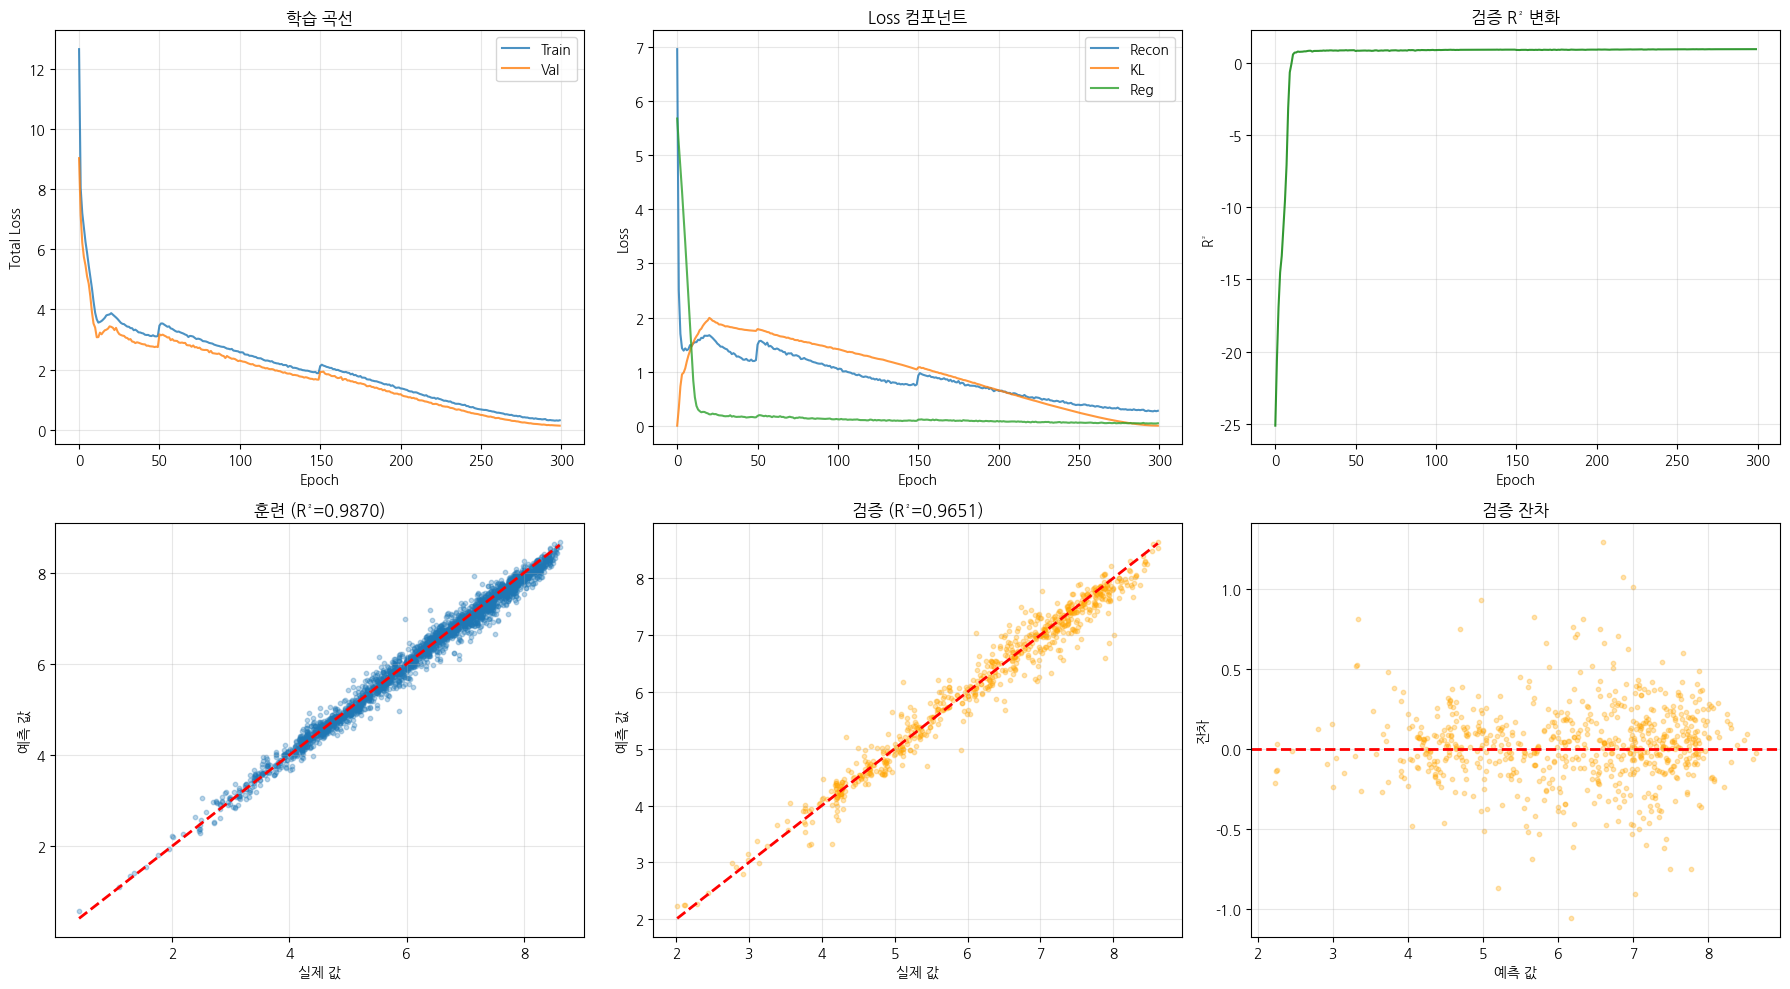

In [9]:
import matplotlib.pyplot as plt

# 개선된 모델 성능 평가
print("=== 개선된 모델 (v1) 성능 평가 ===")

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

model_v1.eval()

# 훈련 데이터 예측
train_preds_v1 = []
train_targets_v1 = []
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        _, _, _, cost_pred = model_v1(xb)
        train_preds_v1.append(cost_pred.cpu().numpy())
        train_targets_v1.append(yb.numpy())

train_preds_v1 = np.concatenate(train_preds_v1)
train_targets_v1 = np.concatenate(train_targets_v1)

# 검증 데이터 예측
val_preds_v1 = []
val_targets_v1 = []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        _, _, _, cost_pred = model_v1(xb)
        val_preds_v1.append(cost_pred.cpu().numpy())
        val_targets_v1.append(yb.numpy())

val_preds_v1 = np.concatenate(val_preds_v1)
val_targets_v1 = np.concatenate(val_targets_v1)

# 성능 지표
train_mse_v1 = mean_squared_error(train_targets_v1, train_preds_v1)
train_mae_v1 = mean_absolute_error(train_targets_v1, train_preds_v1)
train_r2_v1 = r2_score(train_targets_v1, train_preds_v1)

val_mse_v1 = mean_squared_error(val_targets_v1, val_preds_v1)
val_mae_v1 = mean_absolute_error(val_targets_v1, val_preds_v1)
val_r2_v1 = r2_score(val_targets_v1, val_preds_v1)

print(f"\n훈련 데이터:")
print(f"  MSE: {train_mse_v1:.6f}")
print(f"  MAE: {train_mae_v1:.6f}")
print(f"  R²:  {train_r2_v1:.6f}")

print(f"\n검증 데이터:")
print(f"  MSE: {val_mse_v1:.6f}")
print(f"  MAE: {val_mae_v1:.6f}")
print(f"  R²:  {val_r2_v1:.6f}")

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 학습 곡선
axes[0, 0].plot(history_v1['train_loss'], label='Train', alpha=0.8)
axes[0, 0].plot(history_v1['val_loss'], label='Val', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('학습 곡선')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss 컴포넌트
axes[0, 1].plot(history_v1['train_recon'], label='Recon', alpha=0.8)
axes[0, 1].plot(history_v1['train_kl'], label='KL', alpha=0.8)
axes[0, 1].plot(history_v1['train_reg'], label='Reg', alpha=0.8)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Loss 컴포넌트')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# R² 곡선
axes[0, 2].plot(history_v1['val_r2'], color='green', alpha=0.8)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('R²')
axes[0, 2].set_title('검증 R² 변화')
axes[0, 2].grid(True, alpha=0.3)

# 예측 vs 실제 (훈련)
axes[1, 0].scatter(train_targets_v1, train_preds_v1, alpha=0.3, s=10)
axes[1, 0].plot([train_targets_v1.min(), train_targets_v1.max()], 
               [train_targets_v1.min(), train_targets_v1.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('실제 값')
axes[1, 0].set_ylabel('예측 값')
axes[1, 0].set_title(f'훈련 (R²={train_r2_v1:.4f})')
axes[1, 0].grid(True, alpha=0.3)

# 예측 vs 실제 (검증)
axes[1, 1].scatter(val_targets_v1, val_preds_v1, alpha=0.3, s=10, color='orange')
axes[1, 1].plot([val_targets_v1.min(), val_targets_v1.max()], 
               [val_targets_v1.min(), val_targets_v1.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('실제 값')
axes[1, 1].set_ylabel('예측 값')
axes[1, 1].set_title(f'검증 (R²={val_r2_v1:.4f})')
axes[1, 1].grid(True, alpha=0.3)

# 잔차 플롯
residuals_val_v1 = val_targets_v1 - val_preds_v1
axes[1, 2].scatter(val_preds_v1, residuals_val_v1, alpha=0.3, s=10, color='orange')
axes[1, 2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 2].set_xlabel('예측 값')
axes[1, 2].set_ylabel('잔차')
axes[1, 2].set_title('검증 잔차')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== 개선된 모델 (v1) 성능 평가 ===

훈련 데이터:
  MSE: 0.021375
  MAE: 0.108209
  R²:  0.989307

검증 데이터:
  MSE: 0.055621
  MAE: 0.169367
  R²:  0.969708


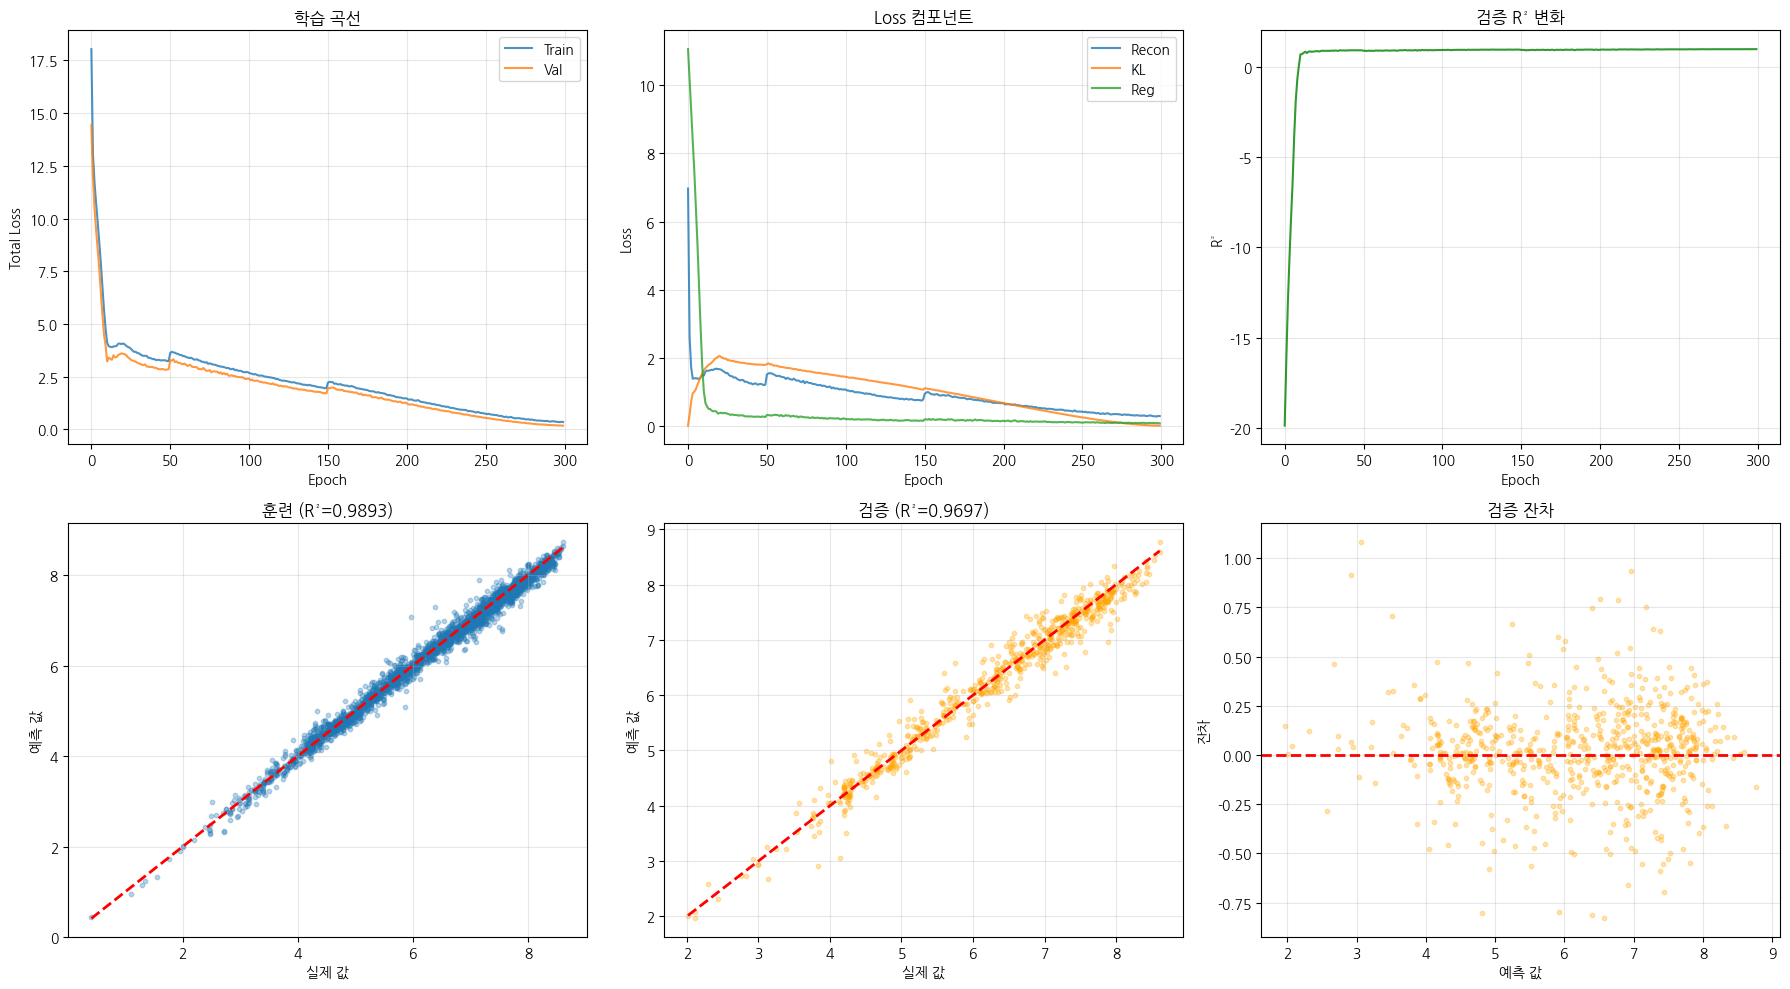

In [11]:
import matplotlib.pyplot as plt

# 개선된 모델 성능 평가
print("=== 개선된 모델 (v1) 성능 평가 ===")

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

model_v1.eval()

# 훈련 데이터 예측
train_preds_v1 = []
train_targets_v1 = []
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        _, _, _, cost_pred = model_v1(xb)
        train_preds_v1.append(cost_pred.cpu().numpy())
        train_targets_v1.append(yb.numpy())

train_preds_v1 = np.concatenate(train_preds_v1)
train_targets_v1 = np.concatenate(train_targets_v1)

# 검증 데이터 예측
val_preds_v1 = []
val_targets_v1 = []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        _, _, _, cost_pred = model_v1(xb)
        val_preds_v1.append(cost_pred.cpu().numpy())
        val_targets_v1.append(yb.numpy())

val_preds_v1 = np.concatenate(val_preds_v1)
val_targets_v1 = np.concatenate(val_targets_v1)

# 성능 지표
train_mse_v1 = mean_squared_error(train_targets_v1, train_preds_v1)
train_mae_v1 = mean_absolute_error(train_targets_v1, train_preds_v1)
train_r2_v1 = r2_score(train_targets_v1, train_preds_v1)

val_mse_v1 = mean_squared_error(val_targets_v1, val_preds_v1)
val_mae_v1 = mean_absolute_error(val_targets_v1, val_preds_v1)
val_r2_v1 = r2_score(val_targets_v1, val_preds_v1)

print(f"\n훈련 데이터:")
print(f"  MSE: {train_mse_v1:.6f}")
print(f"  MAE: {train_mae_v1:.6f}")
print(f"  R²:  {train_r2_v1:.6f}")

print(f"\n검증 데이터:")
print(f"  MSE: {val_mse_v1:.6f}")
print(f"  MAE: {val_mae_v1:.6f}")
print(f"  R²:  {val_r2_v1:.6f}")

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 학습 곡선
axes[0, 0].plot(history_v1['train_loss'], label='Train', alpha=0.8)
axes[0, 0].plot(history_v1['val_loss'], label='Val', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('학습 곡선')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss 컴포넌트
axes[0, 1].plot(history_v1['train_recon'], label='Recon', alpha=0.8)
axes[0, 1].plot(history_v1['train_kl'], label='KL', alpha=0.8)
axes[0, 1].plot(history_v1['train_reg'], label='Reg', alpha=0.8)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Loss 컴포넌트')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# R² 곡선
axes[0, 2].plot(history_v1['val_r2'], color='green', alpha=0.8)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('R²')
axes[0, 2].set_title('검증 R² 변화')
axes[0, 2].grid(True, alpha=0.3)

# 예측 vs 실제 (훈련)
axes[1, 0].scatter(train_targets_v1, train_preds_v1, alpha=0.3, s=10)
axes[1, 0].plot([train_targets_v1.min(), train_targets_v1.max()], 
               [train_targets_v1.min(), train_targets_v1.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('실제 값')
axes[1, 0].set_ylabel('예측 값')
axes[1, 0].set_title(f'훈련 (R²={train_r2_v1:.4f})')
axes[1, 0].grid(True, alpha=0.3)

# 예측 vs 실제 (검증)
axes[1, 1].scatter(val_targets_v1, val_preds_v1, alpha=0.3, s=10, color='orange')
axes[1, 1].plot([val_targets_v1.min(), val_targets_v1.max()], 
               [val_targets_v1.min(), val_targets_v1.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('실제 값')
axes[1, 1].set_ylabel('예측 값')
axes[1, 1].set_title(f'검증 (R²={val_r2_v1:.4f})')
axes[1, 1].grid(True, alpha=0.3)

# 잔차 플롯
residuals_val_v1 = val_targets_v1 - val_preds_v1
axes[1, 2].scatter(val_preds_v1, residuals_val_v1, alpha=0.3, s=10, color='orange')
axes[1, 2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 2].set_xlabel('예측 값')
axes[1, 2].set_ylabel('잔차')
axes[1, 2].set_title('검증 잔차')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()